### 03 - OUTPUTS EXPLORATION

#### 03.1 - Libraries import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 03.2 - Temporal patterns analysis -> TO BE REVIEWED

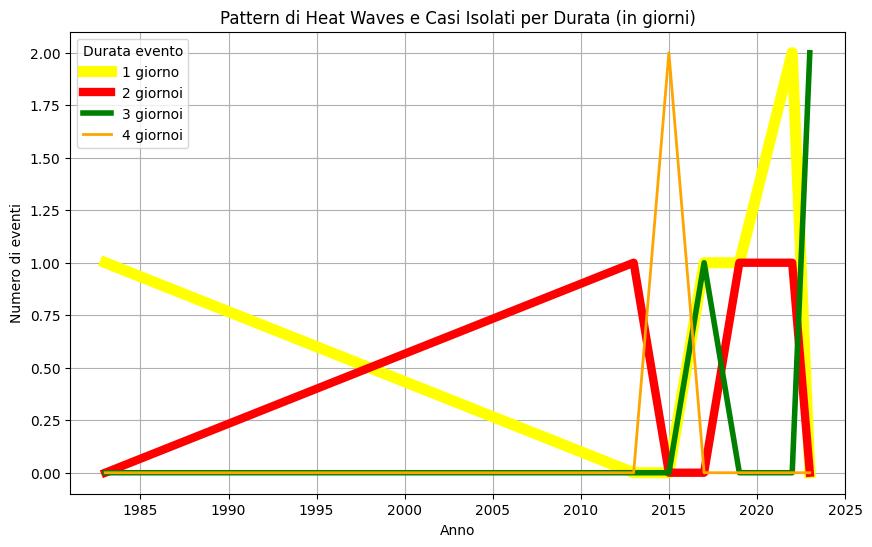

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ LETTURA DEL CSV ------------------
csv_file = "heatwave_timestamps_all.csv"
df_heatwave = pd.read_csv(csv_file)

# Assicurati che la colonna "Data" sia in formato datetime e crea la colonna "Year"
df_heatwave["Data"] = pd.to_datetime(df_heatwave["Data"]).dt.date
df_heatwave["Year"] = pd.to_datetime(df_heatwave["Data"]).dt.year

# ------------------ CALCOLO DEI RUN LENGTH PER OGNI ANNO ------------------
def compute_run_lengths(dates):
    """Data una lista ordinata di date (oggetti date), restituisce la lista delle lunghezze
    delle sequenze consecutive (differenza di 1 giorno tra date successive)."""
    if len(dates) == 0:
        return []
    run_lengths = []
    current_run = 1
    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days == 1:
            current_run += 1
        else:
            run_lengths.append(current_run)
            current_run = 1
    run_lengths.append(current_run)
    return run_lengths

# Raggruppa per anno e ottieni, per ciascun anno, i giorni unici in cui è avvenuto l'evento
grouped = df_heatwave.groupby("Year")["Data"].apply(lambda x: sorted(x.unique())).reset_index()
# Per ogni anno calcola le lunghezze delle sequenze consecutive
grouped["RunLengths"] = grouped["Data"].apply(compute_run_lengths)

# Costruisci un DataFrame in cui per ogni anno e per ogni lunghezza (run length) viene conteggiato il numero di sequenze
records = []
for _, row in grouped.iterrows():
    year = row["Year"]
    run_lengths = row["RunLengths"]
    if len(run_lengths) == 0:
        continue
    unique_lengths, counts = np.unique(run_lengths, return_counts=True)
    for length, cnt in zip(unique_lengths, counts):
        records.append({"Year": year, "RunLength": length, "Count": cnt})
df_runs = pd.DataFrame(records)

# ------------------ CREAZIONE DEL GRAFICO ------------------
# Pivot: righe=Year, colonne=RunLength, valori=Count
df_pivot = df_runs.pivot(index="Year", columns="RunLength", values="Count").fillna(0)

# Definisci lo stile per ciascuna durata (run length)
line_styles = {
    1: {"linewidth": 8, "color": "yellow"},    # eventi isolati (1 giorno)
    2: {"linewidth": 6, "color": "red"},      # eventi di 2 giorni consecutivi
    3: {"linewidth": 4, "color": "green"},    # heat wave: 3 giorni consecutivi
    4: {"linewidth": 2, "color": "orange"},   # eventi di 4 giorni consecutivi
    # Aggiungi ulteriori definizioni se necessario
}

plt.figure(figsize=(10, 6))
# Per ogni lunghezza (colonna) disegna una linea con lo spessore e il colore definiti
for run_length in sorted(df_pivot.columns):
    style = line_styles.get(run_length, {"linewidth": 2, "color": None})  # default se non definito
    plt.plot(df_pivot.index, df_pivot[run_length], linewidth=style["linewidth"], color=style["color"],
             label=f"{run_length} giorno{'i' if run_length > 1 else ''}")
plt.xlabel("Anno")
plt.ylabel("Numero di eventi")
plt.title("Pattern di Heat Waves e Casi Isolati per Durata (in giorni)")
plt.legend(title="Durata evento")
plt.grid(True)
plt.show()